<a href="https://colab.research.google.com/github/sohyeondian/KEI/blob/main/test_0104.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install albumentations==0.4.6

In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

DIR_INPUT = '/content/drive/MyDrive/Colab Notebooks/data2'
# DIR_TRAIN = f'{DIR_INPUT}/train'
# DIR_TEST = f'{DIR_INPUT}/test'

In [ ]:
# train data 불러오기
origin_dir = f'{DIR_INPUT}/origin'
file_list = os.listdir(origin_dir)
# 파일 형식 빼기
file_list = [id[:-4] for id in file_list]
file_list[5]

'100_0022_0143'

In [ ]:
print("Image 개수 :", len(file_list) )
# train, valid로 분할
valid_ids = file_list[-30:]

train_ids = file_list[:-30]
print("train 개수 :", len(train_ids))
print("valid 개수 :", len(valid_ids))

Image 개수 : 147
train 개수 : 117
valid 개수 : 30


In [ ]:
def connectedComponentLabeling(image_id):
    src = cv2.imread(f'{DIR_INPUT}/mask/{image_id}_1.png', cv2.IMREAD_GRAYSCALE)
    _, src_bin = cv2.threshold(src, 0, 255, cv2.THRESH_OTSU) #이진화

    cnt, labels, stats, centroids = cv2.connectedComponentsWithStats(src_bin)
    print(stats)
    return stats[1:]
    
index = 7
image_id = "100_0022_0143"
# 이미지 id가 같은 데이터프레임 가져오기

# 이미지 불러오기 cv2(OpenCV) 사용
image = cv2.imread(f'{DIR_INPUT}/origin/{image_id}.JPG', cv2.IMREAD_COLOR)
# OpenCV가 컬러를 저장하는 방식인 BGR을 RGB로 변환
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.0 # 0 ~ 1로 스케일링

stats = connectedComponentLabeling(image_id)
boxes = stats[:, :-1] 
boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
area = stats[:,-1]
# tensor 값으로 변환
area = torch.as_tensor(area, dtype=torch.float32)
print(area)

if len(boxes) == 0:
  boxes = torch.zeros((0, 4), dtype=torch.float32)
else:
  boxes = torch.as_tensor(boxes, dtype=torch.float32)

# there is only one class => 객체는 한 종류만 존재
print(image.shape)
labels = torch.ones((len(stats),), dtype=torch.int64)
print(labels)
# 모든 인스턴스는 crowd 상태가 아님을 가정
iscrowd = torch.zeros((len(stats),), dtype=torch.int64)
target = {}
target['boxes'] = boxes
print('box', boxes)
target['labels'] = labels
# target['masks'] = None
target['image_id'] = torch.tensor([index])
target['area'] = area
target['iscrowd'] = iscrowd

sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
}
# ** : 딕셔너리형태로 전달 가능
#sample = self.transforms(**sample)
image = sample['image']
#permute : 차원변경?/ bboxes = (x1,y1,x2,y2) / zip *로 풀어서 각 값을 tensor로 바꾸고 다시 튜플로 묶는다.
print(sample['bboxes'].shape)
if len(sample['bboxes']) != 0:
    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
else:
    target['boxes'] = torch.zeros((0, 4), dtype=torch.float32)
print(target['boxes'])

[[       0        0     5472     3648 19923073]
 [    1971        0       13       13      129]
 [    2541        5       13       13      129]
 ...
 [     640     2639       32       22      412]
 [       0     3214       11       11      105]
 [     328     3328       24       19      296]]
tensor([129., 129., 115., 129., 115., 129., 115., 115., 129., 115., 129., 115.,
        129., 129., 129., 115., 115., 115., 115., 115., 115., 115., 129., 129.,
        129., 115., 115., 129., 115., 115., 129., 129., 129., 129., 115., 115.,
        115., 115., 115., 115., 129., 115., 129., 129., 115., 115., 129., 115.,
        115., 129., 115., 115., 115., 115., 115., 115., 129., 115., 129., 129.,
        129., 115., 115., 129., 129., 129., 129., 115., 129., 129., 115., 129.,
        115., 129., 115., 115., 115., 115., 115., 115., 115., 129., 129., 115.,
        185., 115., 115., 115., 129., 129., 115., 115., 115., 129., 311., 115.,
        115., 115., 115., 115., 129., 129., 115., 129., 115., 129.

In [ ]:
class CrapsDataset(Dataset):

    def __init__(self, file_list, DIR_INPUT, transforms=None):
        super().__init__()
        
        self.image_ids = file_list
        self.image_dir = DIR_INPUT
        self.transforms = transforms

    def __getitem__(self, index: int):
        # 이미지 index로 아이템 불러오기

        image_id = self.image_ids[index]
        # 이미지 id가 같은 데이터프레임 가져오기

        # 이미지 불러오기 cv2(OpenCV) 사용
        image = cv2.imread(f'{self.image_dir}/origin/{image_id}.JPG', cv2.IMREAD_COLOR)
        # OpenCV가 컬러를 저장하는 방식인 BGR을 RGB로 변환
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0 # 0 ~ 1로 스케일링

        stats = self.connectedComponentLabeling(image_id)
        # x2, y2값 찾기
        boxes = stats[:,:-1]
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = stats[:,-1]

        # tensor 값으로 변환
        area = torch.as_tensor(area, dtype=torch.float32)

        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class => 객체는 한 종류만 존재
        labels = torch.ones((len(stats),), dtype=torch.int64)
        # 모든 인스턴스는 crowd 상태가 아님을 가정
        iscrowd = torch.zeros((len(stats),), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            # ** : 딕셔너리형태로 전달 가능
            sample = self.transforms(**sample)
            image = sample['image']
            #permute : 차원변경?/ bboxes = (x1,y1,x2,y2) / zip *로 풀어서 각 값을 tensor로 바꾸고 다시 튜플로 묶는다.
            if len(sample['bboxes']) != 0:
                target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
            else:
                target['boxes'] = torch.zeros((0, 4), dtype=torch.float32)
        
        return image, target, image_id
    
    def connectedComponentLabeling(self, image_id):
        src = cv2.imread(f'{self.image_dir}/mask/{image_id}_2.png', cv2.IMREAD_GRAYSCALE)
        _, src_bin = cv2.threshold(src, 0, 255, cv2.THRESH_OTSU) #이진화

        cnt, labels, stats, centroids = cv2.connectedComponentsWithStats(src_bin)
        
        return stats[1:] # 각각의 객체 정보에 들어가기 위해 반복문. 배경을 제외하기 위해 0번째 생략

    def __len__(self) -> int:
        return len(self.image_ids)

In [ ]:
# Albumentations
def get_train_transform():
    return A.Compose([
        # 이미지 뒤집기
        A.Flip(0.5),
        # ToTensor의 역할 = 텐서자료형으로 바꾸기
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [ ]:
num_classes = 2  # 1 class (wheat) + background

# 모델의 차원 정보 얻기
in_features = model.roi_heads.box_predictor.cls_score.in_features

# 모델의 차원, 새로 정의한 클래스 개수로 헤드 교체
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch)) # unzip

train_dataset = CrapsDataset(train_ids, DIR_INPUT, get_train_transform())
valid_dataset = CrapsDataset(valid_ids, DIR_INPUT, get_valid_transform())


# split the dataset in train and test set
# index = torch.randperm(len(train_dataset)).tolist() # 개수만큼 난수 순열

train_data_loader = DataLoader(
    train_dataset,
    batch_size=1, # gpu 성능문제
    shuffle=False,
    num_workers=2, # 멀티프로세싱
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=1,
    collate_fn=collate_fn
)

In [ ]:
# 디바이스 cuda -> 없으면 cpu
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
print(len(train_dataset))

117


In [ ]:
# data 처음부터 읽어오기
images, targets, image_ids = next(iter(train_data_loader))
#print(images[0])
# 모든 모듈의 매개변수와 버퍼를 CUDA tensor로 변경
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
print(len(images))

2


In [ ]:
# 박스 좌표값 int형으로 변경
index = 1
boxes = targets[index]['boxes'].cpu().numpy().astype(np.int32)
print(boxes)
# 차원 변경
print(images[index].shape)
sample = images[index].permute(1,2,0).cpu().numpy()
print(sample.shape)

[[2433   12 2447   24]
 [2891   16 2904   30]
 [2297   21 2309   34]
 ...
 [3451 3366 3464 3379]
 [2119 3369 2132 3382]
 [2500 3456 2515 3469]]
torch.Size([3, 3648, 5472])
(3648, 5472, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


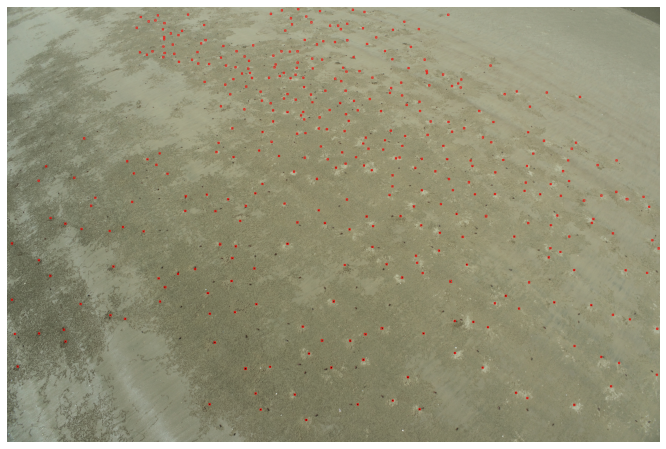

In [ ]:
# 이미지에 박스 표시
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [ ]:
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr = 0.001, momentum=0.9, weight_decay=0.005)
lr_scheduler = None

num_epochs = 2

In [ ]:
class Averager:
  def __init__(self):
    self.current_total = 0.0
    self.iterations = 0.0

  def send(self, value):
    self.current_total += value
    self.iterations += 1

  @property
  def value(self):
    if self.iterations == 0: return 0
    else : return 1.0 * self.current_total / self.iterations

  def reset(self):
    self.current_total = 0.0
    self.iterations = 0.0

In [ ]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
  loss_hist.reset()

  for images, targets, image_ids in train_data_loader:
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    loss_dict = model(images, targets)

    losses = sum(loss for loss in loss_dict.values())
    loss_value = losses.item()

    loss_hist.send(loss_value)

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    if itr % 50 == 0 :
      print(f'Iteration #{itr} loss : {loss_value}')

    itr += 1

  if lr_scheduler is not None:
    lr_scheduler.step()

  print(f"Epoch #{epoch} loss : {loss_hist.value}")

Iteration #50 loss : 1.2398250272210805
Iteration #100 loss : 1.0396216265676375
Epoch #0 loss : 1.1140051592269398
Iteration #150 loss : 1.072242729335017
Iteration #200 loss : 0.8262489833463769
Epoch #1 loss : 1.0423423122370896


In [ ]:
images, targets, image_ids = next(iter(valid_data_loader))
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [ ]:
boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1].permute(1,2,0).cpu().numpy()

model.eval() # eval : 평가하는 과정에서는 모든 노드를 사용하겠다는 의미(dropout 없음)
cpu_device = torch.device("cpu") # 한장이라서??

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

In [ ]:
num = 1
print(outputs[num]['boxes'].int())
print(targets[num]['boxes'], image_ids[num])

tensor([[ 226, 3626,  239, 3637],
        [1816, 3236, 1828, 3249],
        [ 975, 2455,  989, 2469],
        [ 310, 3114,  323, 3126],
        [2744, 3316, 2757, 3328],
        [ 231, 3624,  244, 3636],
        [ 511, 3328,  523, 3340],
        [ 227, 3619,  240, 3632],
        [1413, 3071, 1425, 3084],
        [1795, 3459, 1807, 3473],
        [1903, 3492, 1917, 3506],
        [ 236, 1791,  248, 1804],
        [ 186, 3171,  198, 3183],
        [2175, 3577, 2188, 3589],
        [ 317, 3171,  330, 3184],
        [1415, 3592, 1428, 3604],
        [2091, 3514, 2106, 3528],
        [ 253, 1484,  266, 1498],
        [2746, 3312, 2758, 3324],
        [ 233, 3623,  243, 3632],
        [1908, 3493, 1922, 3506],
        [ 817, 3168,  829, 3180],
        [2399, 3622, 2413, 3633],
        [ 792, 2278,  806, 2291],
        [ 255, 1481,  269, 1496],
        [1816, 3232, 1830, 3245],
        [2150, 2297, 2163, 2309],
        [1412, 3594, 1424, 3607],
        [ 184, 3168,  196, 3181],
        [ 815,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


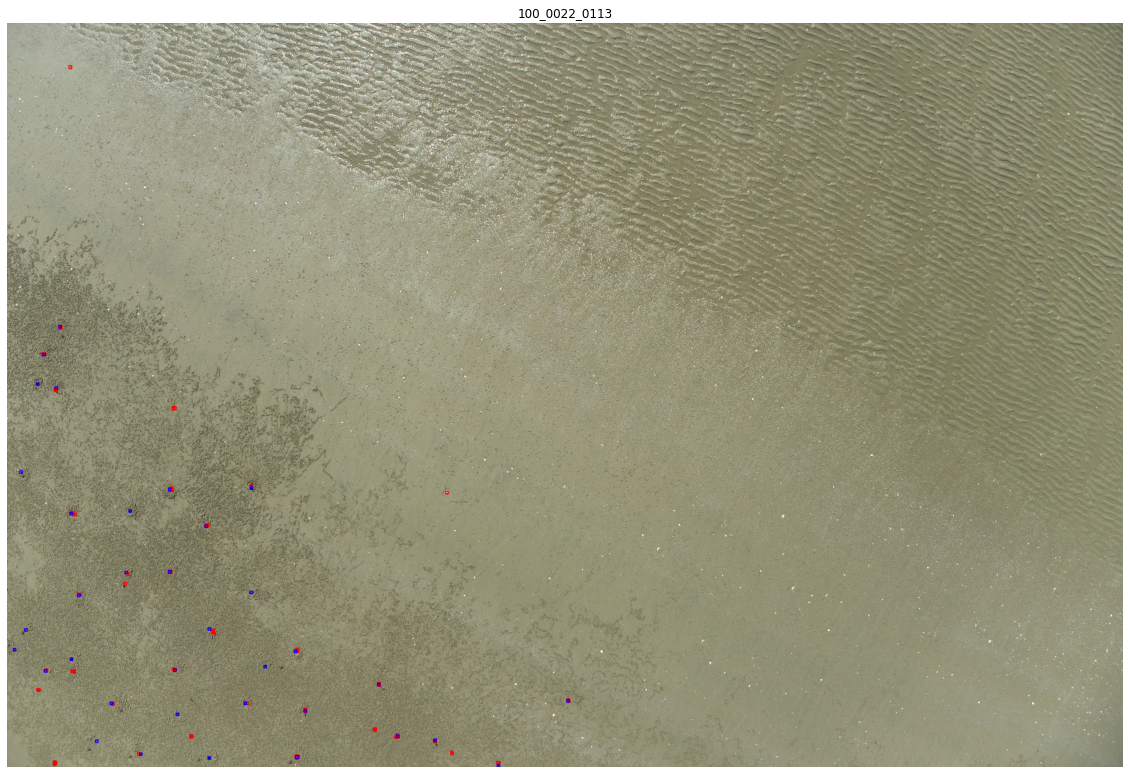

In [ ]:
sample = images[num].permute(1,2,0).cpu().numpy()
boxes = targets[num]['boxes'].cpu().numpy().astype(np.int32)
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

for box in outputs[num]['boxes'].int():
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 4)
for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (0, 0, 220), 3)
ax.set_axis_off()
ax.set_title(image_ids[num])
ax.imshow(sample)